In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
import seaborn as sns
import pandas as pd

from datasets import blobs

## Classification in low-dimensional spaces
Here, we want to illustrate: 
- Intuitive aspects of classification in low-dimensional spaces
- Generate data from a distribution on the plane, visualize it, and classify it
- How the classification depends on the distance between the means of the classes and the variance of the classes

You might be wondering why we are looking at distances and angles in high-dimensional vector spaces. You might also be asking yourself: does it matter for anything in data science? The answer is: YES!!!

The reason is that, although we have been setting up the idea that linear algebra allows us to generalize many of the concepts from the familiar Euclidean two-dimensional plane and Euclidean three-dimensional space, it is also true that *high-dimensional Euclidean vector spaces look nothing like low-dimensional Euclidean vetor spaces*. There are various ways to formalize this, mostly having to do with distances and angles, since distances and angles are the things we used to build up linear algebra. As a practical matter, this matters since many of the intuitions that you have about low-dimensional Euclidean spaces are completely incorrect when dealing with data that are modeled by vectors in high-dimensional Euclidean spaces.

To illustrate this, recall that in the first class, we had an example with triangles on the left side of the board and squares on the right side of the board, and if you were asked about a new data point on the right side of the board, you said that most likely it was a square. To do that, you clustered the data into two clusters, and then you classified the new data point. In both cases, you used distance information and/or angle information.

Here, let's revisit this in more detail, and let's see how things are different if the data vectors are in  $\mathbb{R}^{2}$ than if they are in $\mathbb{R}^{100}$.

### Generating random points in $\mathbb{R}^2$

Our goal here is to understand properties of low-dimensional versus high-dimensional spaces, as a function of the means and variances. To simplify things, we will work with Gaussian distributions, but there is nothing special about Gaussian distributions, and similar phenomena hold more generally. 

Let's start by generating some points in the plane. We draw $10,000$ random points in $\mathbb{R}^2$, where the both the $x_1$- and $x_2$-coordinates of the points are independent draws from a standard Gaussian distribution $\mathscr{N}(\mu = 0, \sigma^2 = 1)$

In [2]:
X, y = blobs(n_samples=10000, n_features=2, center1=0, cluster_std=[1])

We can use a `jointplot` function form the seaborn library to visualize the data. In addition to the scatter plot, we also plot the joint distribution in $\mathbb{R}^2$ to show that indeed each coordinate direction follows a $\mathscr{N}(0, 1)$ Gaussian distribution in $\mathbb{R}^1$ by itself. Essentially, we are projecting the data to the first axis or to the second axis. (By the way, it really is a "projection," in the linear algebra sense, along the first or second canonical vector.)

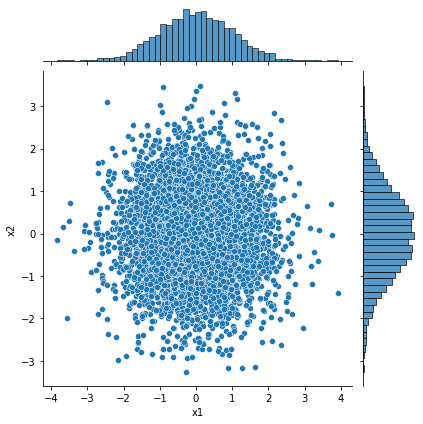

In [3]:
df = pd.DataFrame(data={'x1': X[:,0], 'x2': X[:,1]})
sns.jointplot(data=df, x="x1", y="x2")

#### Two groups: different means, same variance

Consider the situation where there are two different processes creating random points, and we want to try to distinguish, or classify, which points were created by which process. For now we will just simulate this situation without trying to answer the question of how to classify the points, but that will be our ultimate goal. For the sake of reference we will call the first process "Process A" and the second process "Process B".

All of the coordinates of every point generated by Process A are independent draws from a normal distribution. Similar, all of the coordinates of every point generated by Process B are independent draws from a normal distribution.

In [4]:
X, y = blobs(n_samples=10000, n_features=2, center1=0, center2=0, cluster_std=[1,1])

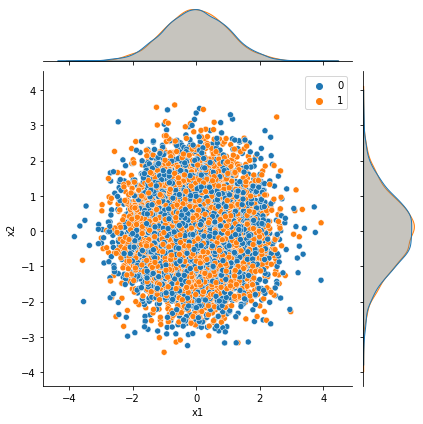

In [5]:
df = pd.DataFrame(data={'x1': X[:,0], 'x2': X[:,1], 'y': y})
sns.jointplot(data=df, x="x1", y="x2", hue=y)

We can also change the centers of the clusters so that that the blobs become well seperated. 

In [6]:
X, y = blobs(n_samples=10000, n_features=2, center1=-2, center2=6, cluster_std=[1,1])

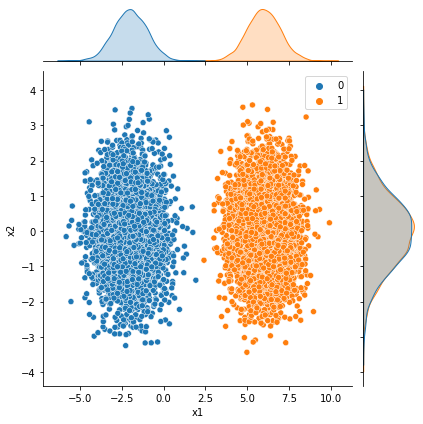

In [7]:
df = pd.DataFrame(data={'x1': X[:,0], 'x2': X[:,1], 'y': y})
sns.jointplot(data=df, x="x1", y="x2", hue=y)

Next, we chose centers so that we achiev some but not complete seperation between the two distributions of points under Process A and Process B.

In [8]:
X, y = blobs(n_samples=10000, n_features=2, center1=0, center2=2, cluster_std=[1,1])

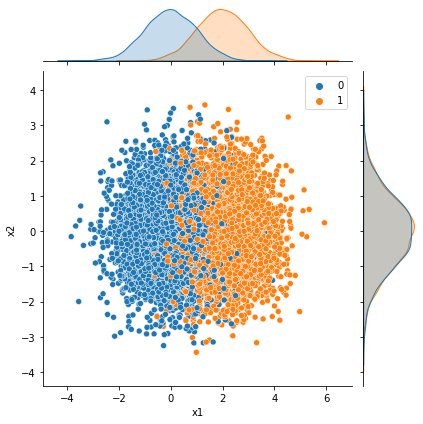

In [9]:
df = pd.DataFrame(data={'x1': X[:,0], 'x2': X[:,1], 'y': y})
sns.jointplot(data=df, x="x1", y="x2", hue=y)

#### Two groups: same means and different variances
In this problem, the means of all coordinates in both processes are equal to 0. The only differences now between Process A and Process B will be between the variances of the normal distributions from which each coordinates was sampled.

In [10]:
X, y = blobs(n_samples=10000, n_features=2, center1=0, center2=0, cluster_std=[1,2])

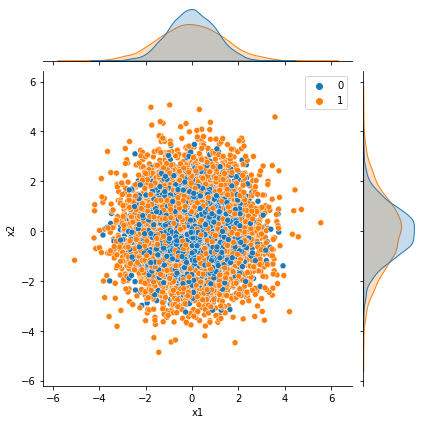

In [11]:
df = pd.DataFrame(data={'x1': X[:,0], 'x2': X[:,1], 'y': y})
sns.jointplot(data=df, x="x1", y="x2", hue=y)

In [12]:
X, y = blobs(n_samples=10000, n_features=2, center1=0, center2=0, cluster_std=[1,10])

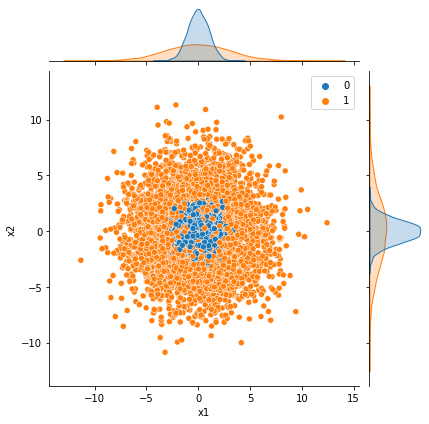

In [13]:
df = pd.DataFrame(data={'x1': X[:,0], 'x2': X[:,1], 'y': y})
sns.jointplot(data=df, x="x1", y="x2", hue=y)

If you were asked to use one statistical measure (e.g. mean, standard deviation, variance) to best separate the two different colored cluters of points into their distinct color group, what would be your choice of the statistical measure? Using your choice of measure, in which of those two plots above would it be the most difficult to best separate the two clusters using your choice of measure? And in which plot above would it be the least difficult? Provide reasoning.

### Classification in $\mathbb{R}^2$, Varying Distance (Center)

Now let's do some classification! As seen in Data 8, classification requires training your classifier and determining how accurate our classifier is on a validation set. We will use the same random-point-generating processes, **Process A** and **Process B**, from the previous part, and then apply a toy classifier to distinguish points generated by **Process A** from points generated by **Process B**. Our goal is to answer this question: how difficult it is to classify points in low dimensions like $\mathbb{R}^2$?

In what follows, we will generate $n$ points total, with each point having a $50\%$ chance of being generated from either **Process A** or **Process B**. 
For this problem, 
- **Process A** will always be centered at $(0,0)$ and have a variance of $1$ in each direction. 
- **Process B** will also have a fixed variance equal to $1$ in each direction, but we will vary the center of **Process B**'s distribution by changing the center's $x_1$-coordinate, for example $(0,0), (1,0), (2,0), ..$. 

The goal of varying the center of **Process B**'s distribution will be to eventually generate two distinct clusters of points. In our plots visualizing this situation, we will again color code points depending on whether they came from **Process A** or from **Process B**.

We will use the k nearest neighbors classifier. This is a very simple distance-based classification algorithm, which you may or may not already be familiar with. For binary classification (i.e. classifying whether a point comes from **Process A** or **Process B**) the algorithm works as follows: 
- Start with a "training" set of data $(x_1, y_1),\dots, (x_n, y_n)$, where $x_i$ is a vector (in this case in $\mathbb{R}^2$), and $y_i$ is a label which is either $0$ or $1$
- Choose an integer $k\geq 1$ 
- For a new "test point" $x_\star$, which we want to classify as either 0 or 1, first calculate the distance between $x_\star$ and each of the training points: $d_i = \|x_\star - x_i\|_2$ for $i=1,\dots,n$
- Then, sort the distances $d_1,\dots, d_n$ from smallest to largest; call these sorted indices $j_1,\dots, j_n$ (where $d_{j_1}$ is the smallest and $d_{j_n}$ is the largest distance)
- Find the $k$ nearest points to $x_\star$, which is $(x_{j_1}, y_{j_1}),\dots, (x_{j_k}, y_{j_k})$, and predict the most common label among these $k$ nearest points: $y_{\text{pred}} = \text{mode}(y_{j_1},\dots, y_{j_k})$ (here $\text{mode}$ just returns the most common value from a list)
    
For more detail, see for instance https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm.

**Remark:** here we chose to use the Euclidean distance to measure how far two points are from each other. However, we could have just as easily used any $L_p$ distance $\|x_\star- x_i\|_p$, or any other distance measure.

For this portion of the notebook, we will use an implementation of k nearest neighbors from the `scikit-learn` package, but it's a good exercise to try implementing the algorithm on your own.
    

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [33]:
X, y = blobs(n_samples=10000, n_features=2, center1=0, center2=3, cluster_std=[1,1])

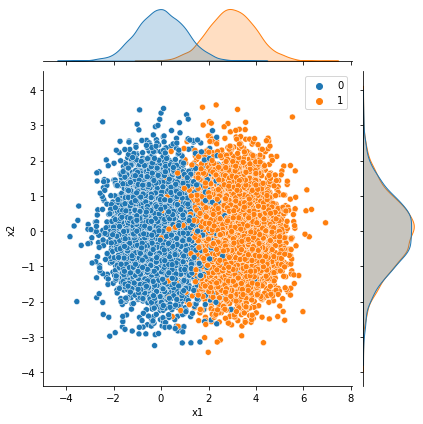

In [34]:
df = pd.DataFrame(data={'x1': X[:,0], 'x2': X[:,1], 'y': y})
sns.jointplot(data=df, x="x1", y="x2", hue=y)

First, we'll split our data into a training and testing set. The testing set will be used to evaluate how good our classifier is at predicting the correct label.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1) 

In [36]:
k = 3 #number of neighbors
p = 2 #Euclidean distance
neigh = KNeighborsClassifier(n_neighbors=k, p=p)
neigh.fit(X_train, y_train)
predicted_label_pts = neigh.predict(X_test)

In [37]:
print('Missclasifcation error', 1-accuracy_score(y_test, predicted_label_pts))

Missclasifcation error 0.08099999999999996


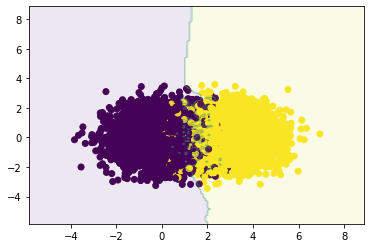

In [39]:
# Adding decision boundary to plot
x1 = np.arange(X[:,0].min()-2, X[:,0].max()+2, 0.1)
x2 = np.arange(X[:,0].min()-2, X[:,0].max()+2, 0.1)
Z = np.zeros((len(x1),len(x2)))

for i in range(len(x1)):
    for j in range(len(x2)):
        Z[i,j] = neigh.predict(np.array([x1[i], x2[j]]).reshape(1, -1))

plt.scatter(X[:,0], X[:,1], c=y)
plt.contourf(x1, x1, Z.T, alpha = 0.1)

Next we slowly shift the center and observe the missclassification error as a function of the distance between the centers.

In [30]:
center_shift = np.arange(0, 5, 0.1)
misclassifcation_rates = []

for shift in center_shift:
    X, y = blobs(n_samples=10000, n_features=2, center1=0, center2=shift, cluster_std=[1,1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train)
    predicted_label_pts = neigh.predict(X_test)
    misclassifcation_rates.append(1-accuracy_score(y_test, predicted_label_pts))

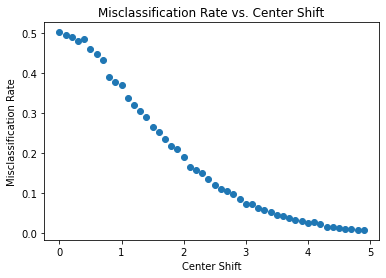

In [31]:
plt.scatter(center_shift, misclassifcation_rates)
plt.xlabel("Center Shift")
plt.ylabel("Misclassification Rate")
plt.title("Misclassification Rate vs. Center Shift")
plt.show()

The key take away from this plot is that classification is easy in $\mathbb{R}^{2}$ if the classes well seperated.

# Build your own k-NN classifier

In [40]:
from scipy.stats import mode

# slow implementation
def knn(X_train, y_train, X_test, num_neighbors):
    preds = list()
    for j in range(X_test.shape[0]):
        
        distances = list()
        for i in range(X_train.shape[0]):
            dist = np.linalg.norm(X_train[i]-X_test[j], ord=2)
            distances.append((X_train[i], dist, y_train[i]))
        distances.sort(key=lambda tup: tup[1])
        neighbors = list()
        for i in range(num_neighbors):
            neighbors.append(distances[i][2])
    
        preds.append(mode(neighbors)[0][0])
    return np.asarray(preds)

In [41]:
# fast implementation -- vectorized
def knn(X_train, y_train, X_test, num_neighbors):
    preds = list()
    for j in range(X_test.shape[0]):
        
        dist = np.linalg.norm(X_train-X_test[j], ord=2, axis=1)
        idx = np.argsort(dist)
        y_train_j = y_train[idx]   
        neighbors = list()
        
        for i in range(num_neighbors):
            neighbors.append(y_train_j[i])
    
        preds.append(mode(neighbors)[0][0])
    return np.asarray(preds) 

In [43]:
center_shift = np.arange(0, 4, 0.3)
misclassifcation_rates = []

for shift in center_shift:
    X, y = blobs(n_samples=1000, n_features=2, center1=0, center2=shift, cluster_std=[1,1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    
    predicted_label_pts = knn(X_train, y_train, X_test, num_neighbors=20)
    misclassifcation_rates.append(1-accuracy_score(y_test, predicted_label_pts))

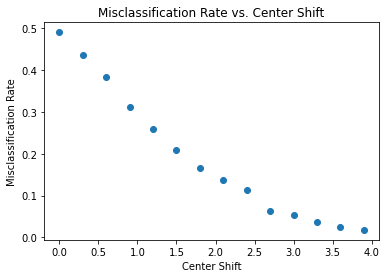

In [44]:
plt.scatter(center_shift, misclassifcation_rates)
plt.xlabel("Center Shift")
plt.ylabel("Misclassification Rate")
plt.title("Misclassification Rate vs. Center Shift")
plt.show()